# Mulitvariate Timeseries forecasting of Dengue Case Counts  
# by Long Short Term Memory using multiple time lags  

For timeseries plotting, autocorrelations and correlations consult the eda_input_prep.ipynb notebook.

The approach taken in this notebook is templated from: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/  

The same author of this site offers other approaches:  

https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/  

https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/  

Long Short-Term Memory (LSTM) is a recurrent neural network that can accommodate a timeseries with multiple input variables, or multivariate timeseries model.

This LSTM model trial is done with Keras deep learning library.

There are a few steps required to prepare the data to be input to the LSTM 
* The raw dataset must be lagged to the desired lag value, and the lagged versions of the variables must be collated for input  
* The variables are scaled using MinMaxScaler and split into training and test datasets* 
* The LSTM is configured and fit
* Training and Test errors are plotted to evaluate whether there's a risk of overfitting
* The RMSE is calculated on the test set to compare against other model frameworks

*This should be done in reverse and will be addressed in the future.  Applying the scaler first is effectively leaking test data to the training.  It will present some complications for converting data back into original units.  It may ultimately prompt a different treatment of the input data as some examples do not lag the variables and concatenate the results.  To be investigated.  

A discussion on the characteristics of an LSTM network is found just before the Define and Fit Model section.  

### Stationarity   

In the eda notebooks, the data was found to be stationary by the Augmented Dickey-Fuller test.

It is generally agreed that the data need not be stationary for LSTM models, however, it is recommended to get an idea of the stationarity of your data anyway as it may inform decisions around the useful life of your model and when a refresh may be required.

https://datascience.stackexchange.com/questions/30362/checking-for-stationarity-in-lstm#:~:text=You%20may%20want%20to%20force,you%20a%20boost%20in%20performance.  

To check for stationarity in Python, consult the following:  
https://machinelearningmastery.com/time-series-data-stationary-python/  

Tests for stationarity, generally:  

"There are various statistical tests to check stationarity, including the Augmented Dickey-Fuller (ADF) test and the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test. The ADF test is a widely used test for checking the stationarity of a time series, and it checks for the presence of a unit root in the data."  (Analytics Vidhya)

## Dengue Case Count Forecasting  

The dataset is described in the eda notebooks (univariate and multivariate focus).  Refer to these for this information.

The objective is to predict weekly dengue case counts given case count and environmental data for prior weeks, this time using more than just one time lag to see if performance improves.

In [197]:
import sys
import os
print("Before anything is modified here are the system path and the current working directory:")
print(sys.path)
print(os.getcwd())
os.chdir('C:\\Users\\ron_d\\lhl_capstone\\multivariate_timeseries_forecasting_dengue')
sys.path.append('C:\\Users\\ron_d\\lhl_capstone\\multivariate_timeseries_forecasting_dengue\\src')
print("\nNow that things have been modified, here are the system path and the current working directory:")
print(sys.path)
print(os.getcwd())

Before anything is modified here are the system path and the current working directory:
['c:\\Users\\ron_d\\lhl_capstone\\multivariate_timeseries_forecasting_dengue\\notebooks', 'c:\\Users\\ron_d\\anaconda3\\envs\\lhl_ds\\python310.zip', 'c:\\Users\\ron_d\\anaconda3\\envs\\lhl_ds\\DLLs', 'c:\\Users\\ron_d\\anaconda3\\envs\\lhl_ds\\lib', 'c:\\Users\\ron_d\\anaconda3\\envs\\lhl_ds', '', 'c:\\Users\\ron_d\\anaconda3\\envs\\lhl_ds\\lib\\site-packages', 'c:\\Users\\ron_d\\anaconda3\\envs\\lhl_ds\\lib\\site-packages\\win32', 'c:\\Users\\ron_d\\anaconda3\\envs\\lhl_ds\\lib\\site-packages\\win32\\lib', 'c:\\Users\\ron_d\\anaconda3\\envs\\lhl_ds\\lib\\site-packages\\Pythonwin', 'C:\\Users\\ron_d\\lhl_capstone\\multivariate_timeseries_forecasting_dengue\\src', 'C:\\Users\\ron_d\\lhl_capstone\\multivariate_timeseries_forecasting_dengue\\src', 'C:\\Users\\ron_d\\lhl_capstone\\multivariate_timeseries_forecasting_dengue\\src', 'C:\\Users\\ron_d\\lhl_capstone\\multivariate_timeseries_forecasting_deng

In [198]:
import numpy as np
import pandas as pd
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
#from pandas import concat  #?
from numpy import concatenate
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from timeseries_data_prep import series_to_supervised_mv, train_test_split_rows_reserved
from scikeras.wrappers import KerasRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

### Data Import and Preparation  

In [199]:
# Get the absolute path to the project directory
project_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Adjust the path to your data file
data_file_path = os.path.join(project_dir, 'multivariate_timeseries_forecasting_dengue', 'data', 'sj_df.csv')

# Read the CSV using the relative path
sj_df = pd.read_csv(data_file_path, header=0, index_col=0)

# For input to series_to_supervised
values = sj_df.values

# Set print options to display more rows and columns
np.set_printoptions(threshold=np.inf, linewidth=np.inf)
pd.set_option('display.max_columns', None)

# Commented out as the lag, n_in, is changed from one case to the next in this notebook.  It's called in each case.
# transform the time series data into supervised learning
#data = series_to_supervised_mv(sj_df_cases_list, n_in=1) # one time lag for my univariate set-up

### LSTM Data Preparation  
Let's prepare the San Juan dengue dataset for the LSTM model.

The dataset has to be "phrased" as a supervised learning problem.  The input variables will be normalized using MinMaxScaler.

The phrasing is:  set up the dataset as a supervised learning problem to predict dengue case counts for the current week (time t) given the case count and environmental variables at the prior time step, or lagged by one week.

The dataset is prepared for a supervised learning approach based on the code proposed here:  
https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

We'll start off with a lag of 4, that is, going four weeks back in the data.

1. The sj_df.csv file is loaded  
2. The variables are normalized  
3. The dataset is structured to be a supervised learning problem  
4. The environmental variables for the current week (time t) are removed; all variables at time t-1 (one lag) and the target at time t are kept

The resultant dataset for input to the LSTM is shown.

> Ideally, an array would be built to take in each variable at its optimal lag value as determined by the correlations done in eda_multivariate. There are results in the xgb_trial_nlags_MV.ipynb notebook on feature importance that could also support this.  It could be a future project.  For now we'll keep it simple and try perhaps 2 different lag values.

##### Best Practices - deviation  

The scaling done below raises some concerns:  normally scaling is done *after* the data have been divided into a training set and a test set to avoid leaking test set characteristics to the training of the model.  This was simply templated from the site mentioned at the start of this notebook as a "how to", and was by no means meant to represent a thoroughly methodologically correct approach.

The scaling done below is done on the entirety of the dataset brought in: features and target (unlagged).  

A pipelining approach will be considered, possibly not in time for project delivery but afterwards, to address scaling correctly and allow for a more streamlined production of models.  This needs to be compatible with the production of lagged input features at varying lags, and needs to have its results inverted back by inversing the scaling at the end to produce the chosen model error metric, MAE, in the original units.  Alternatively, different data preprocessing approaches may be considered to reduce the complexity created in producing lagged datasets ahead of sending this as inputs to the model.

ADDITIONALLY... scaling on "values" (directly below) means EVERYTHING is scaled, including the target.  This has impacts on the predicted values and the error metrics calculated as everything is scaled down to a (0,1) range.  That's why there's manual inverting happening after the model is trained.  The pipeline approach gets around this.

LSTM with lag 4

In [200]:
# ensure all data is float
values = values.astype('float32')
print(values.shape)

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# specify the number of lag hours
# optimal lags found in eda_multivariate vary from 0 to 14, with one group on the lower end, 
# and one group closer to 8.  We can try 4 and then try 8, we'll see what that does to performance.
n_weeks = 4 
n_features = 15 # 14 inputs, 1 output

# frame as supervised learning
reframed = series_to_supervised_mv(scaled, n_weeks, 1)

#print(reframed.head())
reframed.head()

(936, 15)


,var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var6(t-4),var7(t-4),var8(t-4),var9(t-4),var10(t-4),var11(t-4),var12(t-4),var13(t-4),var14(t-4),var15(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var9(t-3),var10(t-3),var11(t-3),var12(t-3),var13(t-3),var14(t-3),var15(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var7(t-2),var8(t-2),var9(t-2),var10(t-2),var11(t-2),var12(t-2),var13(t-2),var14(t-2),var15(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var15(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t),var13(t),var14(t),var15(t)
4,0.008677,0.587840,0.626763,0.523701,0.541889,0.261009,0.269188,0.339931,0.307693,0.452057,0.056091,0.318138,0.031797,0.297392,0.413954,0.010846,0.640416,0.669811,0.435300,0.492142,0.362995,0.384892,0.528473,0.476925,0.520550,0.031446,0.510214,0.058423,0.473460,0.330233,0.008677,0.487412,0.704284,0.422680,0.526662,0.454029,0.456909,0.710358,0.415386,0.643837,0.045749,0.734987,0.088428,0.664509,0.306977,0.006508,0.594546,0.785005,0.594845,0.672866,0.486881,0.514759,0.695110,0.553848,0.602741,0.024365,0.652660,0.039324,0.641761,0.348837,0.013015,0.669649,0.804187,0.652699,0.698613,0.571758,0.586777,0.757843,0.630772,0.671234,0.021385,0.658555,0.019252,0.711300,0.539535
5,0.010846,0.640416,0.669811,0.435300,0.492142,0.362995,0.384892,0.528473,0.476925,0.520550,0.031446,0.510214,0.058423,0.473460,0.330233,0.008677,0.487412,0.704284,0.422680,0.526662,0.454029,0.456909,0.710358,0.415386,0.643837,0.045749,0.734987,0.088428,0.664509,0.306977,0.006508,0.594546,0.785005,0.594845,0.672866,0.486881,0.514759,0.695110,0.553848,0.602741,0.024365,0.652660,0.039324,0.641761,0.348837,0.013015,0.669649,0.804187,0.652699,0.698613,0.571758,0.586777,0.757843,0.630772,0.671234,0.021385,0.658555,0.019252,0.711300,0.539535,0.004338,0.669649,0.706393,0.660320,0.551164,0.589550,0.603306,0.761520,0.707695,0.753426,0.046433,0.631272,0.024526,0.711670,0.241860
6,0.008677,0.487412,0.704284,0.422680,0.526662,0.454029,0.456909,0.710358,0.415386,0.643837,0.045749,0.734987,0.088428,0.664509,0.306977,0.006508,0.594546,0.785005,0.594845,0.672866,0.486881,0.514759,0.695110,0.553848,0.602741,0.024365,0.652660,0.039324,0.641761,0.348837,0.013015,0.669649,0.804187,0.652699,0.698613,0.571758,0.586777,0.757843,0.630772,0.671234,0.021385,0.658555,0.019252,0.711300,0.539535,0.004338,0.669649,0.706393,0.660320,0.551164,0.589550,0.603306,0.761520,0.707695,0.753426,0.046433,0.631272,0.024526,0.711670,0.241860,0.008677,0.577058,0.614532,0.539822,0.615290,0.522018,0.513580,0.763275,0.538464,0.698635,0.067660,0.732451,0.008909,0.714444,0.223256
7,0.006508,0.594546,0.785005,0.594845,0.672866,0.486881,0.514759,0.695110,0.553848,0.602741,0.024365,0.652660,0.039324,0.641761,0.348837,0.013015,0.669649,0.804187,0.652699,0.698613,0.571758,0.586777,0.757843,0.630772,0.671234,0.021385,0.658555,0.019252,0.711300,0.539535,0.004338,0.669649,0.706393,0.660320,0.551164,0.589550,0.603306,0.761520,0.707695,0.753426,0.046433,0.631272,0.024526,0.711670,0.241860,0.008677,0.577058,0.614532,0.539822,0.615290,0.522018,0.513580,0.763275,0.538464,0.698635,0.067660,0.732451,0.008909,0.714444,0.223256,0.010846,0.532151,0.591805,0.408662,0.441663,0.583389,0.564346,0.844929,0.430771,0.794521,0.052585,0.798465,0.386892,0.810616,0.069767
8,0.013015,0.669649,0.804187,0.652699,0.698613,0.571758,0.586777,0.757843,0.630772,0.671234,0.021385,0.658555,0.019252,0.711300,0.539535,0.004338,0.669649,0.706393,0.660320,0.551164,0.589550,0.603306,0.761520,0.707695,0.753426,0.046433,0.631272,0.024526,0.711670,0.241860,0.008677,0.577058,0.614532,0.539822,0.615290,0.522018,0.513580,0.763275,0.538464,0.698635,0.067660,0.732451,0.008909,0.714444,0.223256,0.010846,0.532151,0.591805,0.408662,0.441663,0.583389,0.564346,0.844929,0.430771,0.794521,0.052585,0.798465,0.386892,0.810616,0.069767

In this trial, more time lags are included than in the "one time lag" trial to examine its impact on model performance.  This takes advantage of the LSTM architecture as it retains a "memory" of past information, which makes it particularly suitable for timeseries modelling.

For great diagrams, extensive commenting by readers, and further reading:  https://colah.github.io/posts/2015-08-Understanding-LSTMs/  

Briefly put, LSTMs are a special type of RNN (recurrent neural network) that allows for longer-term retention of information.  To borrow from the above blog post, it's comparable to guessing the next word in a sentence based on previous words, but how far back?  Example:  

"Sometimes, we only need to look at recent information to perform the present task. For example, consider a language model trying to predict the next word based on the previous ones. If we are trying to predict the last word in “the clouds are in the sky,” we don’t need any further context – it’s pretty obvious the next word is going to be sky. In such cases, where the gap between the relevant information and the place that it’s needed is small, RNNs can learn to use the past information."  

"But there are also cases where we need more context. Consider trying to predict the last word in the text “I grew up in France… I speak fluent French.” Recent information suggests that the next word is probably the name of a language, but if we want to narrow down which language, we need the context of France, from further back. It’s entirely possible for the gap between the relevant information and the point where it is needed to become very large.

Unfortunately, as that gap grows, RNNs become unable to learn to connect the information."  

But LSTMs, it appears, can connect information from further back.  I'll let you work out the math ;)


### Define and Fit Model  
In the cells below we'll set up the training and test sets according to the format expected by the Keras LSTM architecture.  We'll then fit the model on the first quarter of the data, for efficiency, and we'll test on the last three quarters of the data.  This fraction or split can be changed for experimentation's sake.  

The below also carefully considers that the code above creates n_hours (lags) times n_features (15 inputs) of lagged columns in the 'reframed' dataset, as well as n_features' worth of non-lagged columns, the last one being the target at time t.  The first n_hours x n_features (lagged) will be kept, and then the last column containing our "present time" target will be kept.  The rows between, that is, the non-time-lagged input features, will be dropped.

In [201]:
sj_df.shape

(936, 15)

The cell directly below integrates the train test split function in the timeseries_data_prep.py module to eliminate these "one of" approaches taken in some of the notebooks.  Once tested and assured of its proper functionality, 

In [202]:
test_frac = 0.75
values = reframed.values
train, test = train_test_split_rows_reserved(values,int(test_frac*sj_df.shape[0]))    

In [203]:
# split into train and test sets
# set the fraction of the dataset you want to use for training
# this is just another take on the train_test_split_rows_reserved function in the timeseries_data_prep.py module.  
# Could replace the below.  As long as the output still works for subsequent steps.
# train_frac = 0.25

# values = reframed.values
# n_train_weeks = int(train_frac*sj_df.shape[0])
# train = values[:n_train_weeks, :]
# test = values[n_train_weeks:, :]

# split into input and outputs; this is where the undesired columns are dropped,
# as opposed to where they were dropped in the one time lag case
n_obs = n_weeks * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features] # if everything was done correctly when the dataframe was hauled in, the target at time t is 15 columns from the end
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_weeks, n_features))
test_X = test_X.reshape((test_X.shape[0], n_weeks, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
print(train_X)

(230, 60) 230 (230,)
(230, 4, 15) (230,) (702, 4, 15) (702,)
[[[0.00867679 0.5878397  0.62676334 0.52370095 0.54188865 0.26100922 0.26918793 0.3399315  0.30769348 0.45205688 0.05609115 0.31813812 0.03179723 0.29739225 0.4139536 ]
  [0.01084599 0.6404157  0.6698108  0.43529975 0.49214232 0.36299515 0.3848915  0.5284729  0.4769249  0.5205498  0.0314461  0.5102136  0.05842294 0.47346032 0.33023256]
  [0.00867679 0.4874118  0.70428425 0.42268026 0.5266624  0.45402908 0.45690918 0.71035767 0.4153862  0.643837   0.04574934 0.7349875  0.08842807 0.66450894 0.3069768 ]
  [0.00650759 0.594546   0.7850053  0.5948448  0.67286634 0.48688126 0.51475906 0.6951103  0.55384827 0.60274124 0.02436459 0.65265965 0.03932412 0.6417607  0.34883726]]

 [[0.01084599 0.6404157  0.6698108  0.43529975 0.49214232 0.36299515 0.3848915  0.5284729  0.4769249  0.5205498  0.0314461  0.5102136  0.05842294 0.47346032 0.33023256]
  [0.00867679 0.4874118  0.70428425 0.42268026 0.5266624  0.45402908 0.45690918 0.71035767 0

The LSTM is configured with 50 neurons in the first hidden layer and 1 neuron in the output layer, per suggestions from https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/  

Different configurations can be selected to experiment and track model performance results.

Predictions will be made using data lagged by one time step, which is a week in our dataset's case.

The Mean Absolute Error (MAE) loss function and Adam version of stochastic gradient descent are chosen for the training mechanism.

The model will be fit for 50 training epochs with a batch size of 72.  More familiarity with standard approaches to testing different configurations will allow for testing on different numbers of layers, numbers of neurons as well as trying different batch sizes and numbers of epochs.

Note the internal state of the LSTM in Keras is reset at the end of each batch.  I believe this pertains to a parameter that determines if the network is stateful or not, which may be set.  This governs whether "internal states" are kept throughout the model (details can be found online).  The consensus on whether the model should be stateful for timeseries is 'yes', so this may be revisited:

https://machinelearningmastery.com/stateful-stateless-lstm-time-series-forecasting-python/ (many other sources concur)

The training and test loss are tracked during training by setting:  the validation_data argument is defined in the fit() function.

On the use of the validation data parameter:  https://datascience.stackexchange.com/questions/109066/validation-split-in-time-series-data-for-lstm-model#:~:text=fit%20%2C%20you%20can%20use%20this,this%20set%20that%20you%20provide.&text=validation_split%3A%20Float%20between%200%20and,be%20used%20as%20validation%20data.  

A plot of the training and test loss is shown after the model finishes training.

In [204]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/50


4/4 - 2s - loss: 0.0926 - val_loss: 0.0674 - 2s/epoch - 404ms/step
Epoch 2/50
4/4 - 0s - loss: 0.0735 - val_loss: 0.0681 - 40ms/epoch - 10ms/step
Epoch 3/50
4/4 - 0s - loss: 0.0853 - val_loss: 0.0857 - 39ms/epoch - 10ms/step
Epoch 4/50
4/4 - 0s - loss: 0.0888 - val_loss: 0.0623 - 38ms/epoch - 10ms/step
Epoch 5/50
4/4 - 0s - loss: 0.0669 - val_loss: 0.0427 - 37ms/epoch - 9ms/step
Epoch 6/50
4/4 - 0s - loss: 0.0600 - val_loss: 0.0447 - 39ms/epoch - 10ms/step
Epoch 7/50
4/4 - 0s - loss: 0.0590 - val_loss: 0.0589 - 40ms/epoch - 10ms/step
Epoch 8/50
4/4 - 0s - loss: 0.0646 - val_loss: 0.0606 - 39ms/epoch - 10ms/step
Epoch 9/50
4/4 - 0s - loss: 0.0614 - val_loss: 0.0502 - 39ms/epoch - 10ms/step
Epoch 10/50
4/4 - 0s - loss: 0.0551 - val_loss: 0.0467 - 38ms/epoch - 10ms/step
Epoch 11/50
4/4 - 0s - loss: 0.0533 - val_loss: 0.0534 - 39ms/epoch - 10ms/step
Epoch 12/50
4/4 - 0s - loss: 0.0543 - val_loss: 0.0556 - 39ms/epoch - 10ms/step
Epoch 13/50
4/4 - 0s - loss: 0.0531 - val_loss: 0.0496 - 39ms/

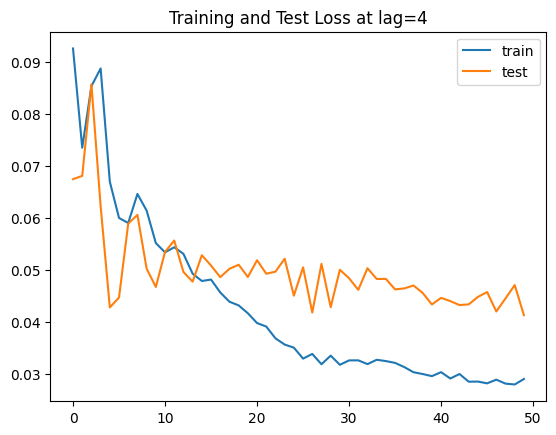

In [205]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.title('Training and Test Loss at lag=4')
pyplot.legend()
pyplot.show()

### Model Performance Metrics  

The fitted or trained model can be used to predict cases for the entire test dataset.  

The multiple time lag set-up requires a few edits over the one time lag scenario for evaluating the model.  Reversing the scaling done on the inputs requires careful reconstruction of the rows and input columns.  

Each of the y and yhat column are concatenated with the last 7 features of the test dataset to invert the scaling.

Once the datasets have the scaling inverted, the root mean squared error (RMSE) and mean absolute error (MAE) are calculated for the model.  

22/22 [==============================] - 0s 1ms/step


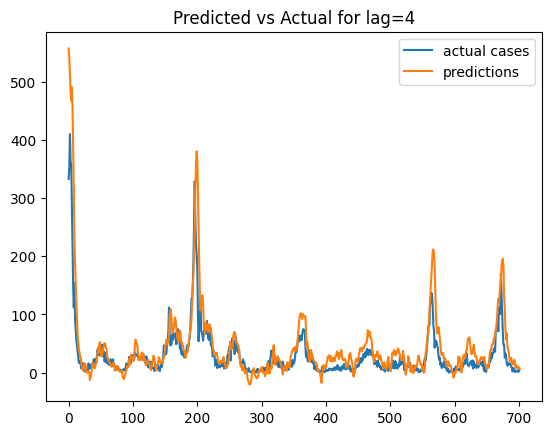

In [206]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_weeks*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -14:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -14:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# plot actual and predicted
pyplot.plot(inv_y, label='actual cases')
pyplot.plot(inv_yhat, label='predictions')
pyplot.title('Predicted vs Actual for lag=4')
pyplot.legend()
pyplot.show()

In [207]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
# calculate MAE
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.3f' % mae)

Test RMSE: 35.254
Test MAE: 19.011


The model reaches a higher RMSE than the model with only 1 time lag.  Note that the RMSE does change with every run as the training has a stochastic element to it.  

#### LSTM with lag 4, larger training set  

The training set size above represents 25% of the full dataset, which may be part of why the model errors are noticeably larger than for other model algorithms trialled in the other notebooks.  Here we'll increase the training set size to 50% and contract the test set size to observe the impact on model performance.

The cell directly below integrates the train test split function in the timeseries_data_prep.py module to eliminate these "one of" approaches taken in some of the notebooks.  Once tested and assured of its proper functionality, 

In [208]:
test_frac = 0.50
values = reframed.values
train, test = train_test_split_rows_reserved(values,int(test_frac*sj_df.shape[0]))    

In [209]:
# split into train and test sets
# set the fraction of the dataset you want to use for training
# this is just another take on the train_test_split_rows_reserved function in the timeseries_data_prep.py module.  
# Could replace the below.  As long as the output still works for subsequent steps.
# train_frac = 0.7

# values = reframed.values
# n_train_weeks = int(train_frac*sj_df.shape[0])
# train = values[:n_train_weeks, :]
# test = values[n_train_weeks:, :]

# split into input and outputs; this is where the undesired columns are dropped,
# as opposed to where they were dropped in the one time lag case
n_obs = n_weeks * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features] # if everything was done correctly when the dataframe was hauled in, the target at time t is 15 columns from the end
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_weeks, n_features))
test_X = test_X.reshape((test_X.shape[0], n_weeks, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(464, 60) 464 (464,)
(464, 4, 15) (464,) (468, 4, 15) (468,)


In [210]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/50
7/7 - 2s - loss: 0.1484 - val_loss: 0.0467 - 2s/epoch - 227ms/step
Epoch 2/50
7/7 - 0s - loss: 0.0949 - val_loss: 0.1251 - 41ms/epoch - 6ms/step
Epoch 3/50
7/7 - 0s - loss: 0.0919 - val_loss: 0.0737 - 40ms/epoch - 6ms/step
Epoch 4/50
7/7 - 0s - loss: 0.0709 - val_loss: 0.0512 - 39ms/epoch - 6ms/step
Epoch 5/50
7/7 - 0s - loss: 0.0662 - val_loss: 0.0796 - 43ms/epoch - 6ms/step
Epoch 6/50
7/7 - 0s - loss: 0.0651 - val_loss: 0.0463 - 40ms/epoch - 6ms/step
Epoch 7/50
7/7 - 0s - loss: 0.0599 - val_loss: 0.0667 - 41ms/epoch - 6ms/step
Epoch 8/50
7/7 - 0s - loss: 0.0591 - val_loss: 0.0427 - 42ms/epoch - 6ms/step
Epoch 9/50
7/7 - 0s - loss: 0.0538 - val_loss: 0.0561 - 41ms/epoch - 6ms/step
Epoch 10/50
7/7 - 0s - loss: 0.0519 - val_loss: 0.0355 - 41ms/epoch - 6ms/step
Epoch 11/50
7/7 - 0s - loss: 0.0475 - val_loss: 0.0419 - 41ms/epoch - 6ms/step
Epoch 12/50
7/7 - 0s - loss: 0.0431 - val_loss: 0.0366 - 42ms/epoch - 6ms/step
Epoch 13/50
7/7 - 0s - loss: 0.0406 - val_loss: 0.0242 - 41ms

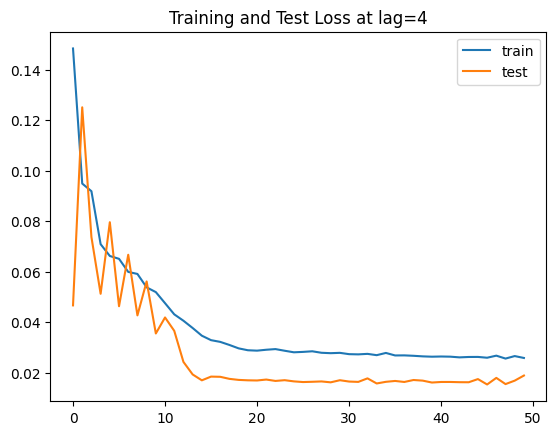

In [211]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.title('Training and Test Loss at lag=4')
pyplot.legend()
pyplot.show()

Observing impact from NOT inverting (reversing scaling).  As the scaler is applied much, much earlier, on the entire dataset "values", it also scaled the y values.  That impacts the predictions and the error metrics.

15/15 [==============================] - 0s 1ms/step


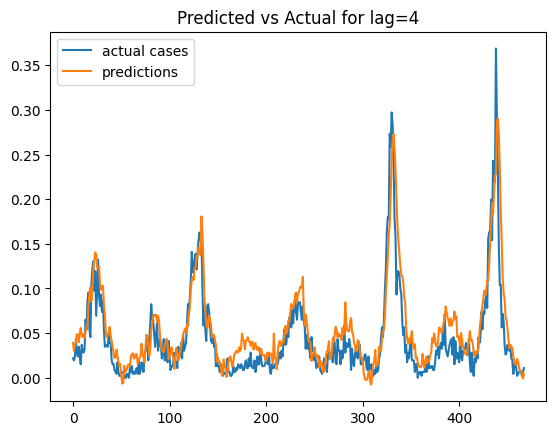

In [212]:
# make a prediction WITHOUT inversion
yhat = model.predict(test_X)
# test_X = test_X.reshape((test_X.shape[0], n_weeks*n_features))
# # invert scaling for forecast
# inv_yhat = concatenate((yhat, test_X[:, -14:]), axis=1)
# inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:,0]
# # invert scaling for actual
# test_y = test_y.reshape((len(test_y), 1))
# inv_y = concatenate((test_y, test_X[:, -14:]), axis=1)
# inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:,0]

# plot actual and predicted
pyplot.plot(test_y, label='actual cases')
pyplot.plot(yhat, label='predictions')
pyplot.title('Predicted vs Actual for lag=4')
pyplot.legend()
pyplot.show()

In [213]:
# UNinverted VALUES
# calculate RMSE
rmse = sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)
# calculate MAE
mae = mean_absolute_error(test_y, yhat)
print('Test MAE: %.3f' % mae)

Test RMSE: 0.026
Test MAE: 0.019


 1/15 [=>............................] - ETA: 0s

15/15 [==============================] - 0s 1ms/step


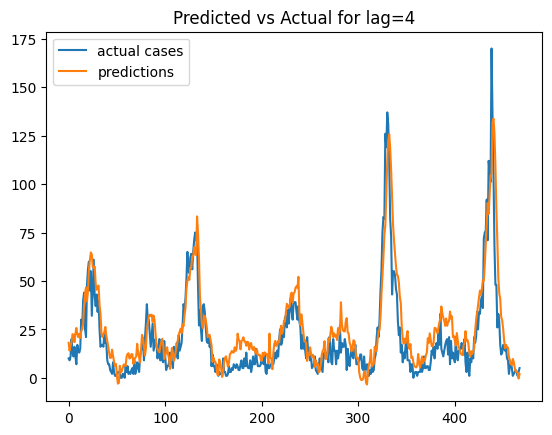

In [214]:
# make a prediction WITH inversion
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_weeks*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -14:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -14:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# plot actual and predicted
pyplot.plot(inv_y, label='actual cases')
pyplot.plot(inv_yhat, label='predictions')
pyplot.title('Predicted vs Actual for lag=4')
pyplot.legend()
pyplot.show()

In [215]:
# INVERTED VALUES
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
# calculate MAE
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.3f' % mae)

Test RMSE: 12.012
Test MAE: 8.691


The above error metrics are a significant improvement on what we were getting with a 25% test set size.

#### LSTM with lag 8  

"Fixed" the "something" that was causing the below to create 75 (instead of 15) columns.  Trouble is, I don't recall why I'm going back to values anyway and re-scaling - what's changed?  Why not just restart from reframed = series_to_supervised for the lag order now specified (8).  I may yet streamline this, or not, if I'm going to focus on pipelines.

In [216]:
# values is set to reframed.values earlier in the notebook.  It may be causing problems, so the below was added:
values = sj_df.values

# ensure all data is float
values = values.astype('float32')
#print(values)
print(values.shape)

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# specify the number of lag hours
# optimal lags found in eda_multivariate vary from 0 to 14, with one group on the lower end, 
# and one group closer to 8.  We can try 4 and then try 8, we'll see what that does to performance.
n_weeks = 8 
n_features = 15 # 14 inputs, 1 output

# frame as supervised learning
reframed = series_to_supervised_mv(scaled, n_weeks, 1)

#print(reframed.head())
reframed.head()

(936, 15)


,var1(t-8),var2(t-8),var3(t-8),var4(t-8),var5(t-8),var6(t-8),var7(t-8),var8(t-8),var9(t-8),var10(t-8),var11(t-8),var12(t-8),var13(t-8),var14(t-8),var15(t-8),var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var6(t-7),var7(t-7),var8(t-7),var9(t-7),var10(t-7),var11(t-7),var12(t-7),var13(t-7),var14(t-7),var15(t-7),var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),var6(t-6),var7(t-6),var8(t-6),var9(t-6),var10(t-6),var11(t-6),var12(t-6),var13(t-6),var14(t-6),var15(t-6),var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var6(t-5),var7(t-5),var8(t-5),var9(t-5),var10(t-5),var11(t-5),var12(t-5),var13(t-5),var14(t-5),var15(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var6(t-4),var7(t-4),var8(t-4),var9(t-4),var10(t-4),var11(t-4),var12(t-4),var13(t-4),var14(t-4),var15(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var9(t-3),var10(t-3),var11(t-3),var12(t-3),var13(t-3),var14(t-3),var15(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var7(t-2),var8(t-2),var9(t-2),var10(t-2),var11(t-2),var12(t-2),var13(t-2),var14(t-2),var15(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var15(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t),var13(t),var14(t),var15(t)
8,0.008677,0.587840,0.626763,0.523701,0.541889,0.261009,0.269188,0.339931,0.307693,0.452057,0.056091,0.318138,0.031797,0.297392,0.413954,0.010846,0.640416,0.669811,0.435300,0.492142,0.362995,0.384892,0.528473,0.476925,0.520550,0.031446,0.510214,0.058423,0.473460,0.330233,0.008677,0.487412,0.704284,0.422680,0.526662,0.454029,0.456909,0.710358,0.415386,0.643837,0.045749,0.734987,0.088428,0.664509,0.306977,0.006508,0.594546,0.785005,0.594845,0.672866,0.486881,0.514759,0.695110,0.553848,0.602741,0.024365,0.652660,0.039324,0.641761,0.348837,0.013015,0.669649,0.804187,0.652699,0.698613,0.571758,0.586777,0.757843,0.630772,0.671234,0.021385,0.658555,0.019252,0.711300,0.539535,0.004338,0.669649,0.706393,0.660320,0.551164,0.589550,0.603306,0.761520,0.707695,0.753426,0.046433,0.631272,0.024526,0.711670,0.241860,0.008677,0.577058,0.614532,0.539822,0.615290,0.522018,0.513580,0.763275,0.538464,0.698635,0.067660,0.732451,0.008909,0.714444,0.223256,0.010846,0.532151,0.591805,0.408662,0.441663,0.583389,0.564346,0.844929,0.430771,0.794521,0.052585,0.798465,0.386892,0.810616,0.069767,0.021692,0.565442,0.674289,0.345285,0.420469,0.581337,0.569065,0.826180,0.661541,0.698635,0.065749,0.769331,0.049462,0.786388,0.172093
9,0.010846,0.640416,0.669811,0.435300,0.492142,0.362995,0.384892,0.528473,0.476925,0.520550,0.031446,0.510214,0.058423,0.473460,0.330233,0.008677,0.487412,0.704284,0.422680,0.526662,0.454029,0.456909,0.710358,0.415386,0.643837,0.045749,0.734987,0.088428,0.664509,0.306977,0.006508,0.594546,0.785005,0.594845,0.672866,0.486881,0.514759,0.695110,0.553848,0.602741,0.024365,0.652660,0.039324,0.641761,0.348837,0.013015,0.669649,0.804187,0.652699,0.698613,0.571758,0.586777,0.757843,0.630772,0.671234,0.021385,0.658555,0.019252,0.711300,0.539535,0.004338,0.669649,0.706393,0.660320,0.551164,0.589550,0.603306,0.761520,0.707695,0.753426,0.046433,0.631272,0.024526,0.711670,0.241860,0.008677,0.577058,0.614532,0.539822,0.615290,0.522018,0.513580,0.763275,0.538464,0.698635,0.067660,0.732451,0.008909,0.714444,0.223256,0.010846,0.532151,0.591805,0.408662,0.441663,0.583389,0.564346,0.844929,0.430771,0.794521,0.052585,0.798465,0.386892,0.810616,0.069767,0.021692,0.565442,0.674289,0.345285,0.420469,0.581337,0.569065,0.826180,0.661541,0.698635,0.065749,0.769331,0.049462,0.786388,0.172093,0.013015,0.565442,0.646720,0.431204,0.597971,0.673286,0.688313,0.859646,0.692307,0.835621,0.049781,0.697971,0.036892,0.822822,0.213954
10,0.008677,0.487412,0.704284,0.422680,0.526662,0.454029,0.456909,0.710358,0.415386,0.643837,0.045749,0.734987,0.088428,0.664509,0.306977,0.006508,0.594546,0.785005,0.594845,0.672866,0.486881

### Define and Fit Model  
As with lag = 4, but now it's 8.

The cell directly below integrates the train test split function in the timeseries_data_prep.py module to eliminate these "one of" approaches taken in some of the notebooks.  Once tested and assured of its proper functionality, 

In [217]:
test_frac = 0.75
values = reframed.values
train, test = train_test_split_rows_reserved(values,int(test_frac*sj_df.shape[0]))    
print(len(train))
print(len(test))

226
702


In [218]:
# split into train and test sets
# set the fraction of the dataset you want to use for training
# need to standardize on train_test_split_rows_reserved function
# train_frac = 0.25

# values = reframed.values
# n_train_weeks = int(train_frac*sj_df.shape[0])
# train = values[:n_train_weeks, :]
# test = values[n_train_weeks:, :]

# split into input and outputs; this is where the undesired columns are dropped,
# as opposed to where they were dropped in the one time lag case
n_obs = n_weeks * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features] # if everything was done correctly when the dataframe was hauled in, the target at time t is 15 columns from the end
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_weeks, n_features))
test_X = test_X.reshape((test_X.shape[0], n_weeks, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(226, 120) 226 (226,)
(226, 8, 15) (226,) (702, 8, 15) (702,)


The same LSTM configuration is used at lag 8 as was used for lag 4:  
* 50 neurons in the first hidden layer
* 1 neuron in the output layer  
* Mean Absolute Error (MAE) loss function
* Adam version of stochastic gradient descent chosen for training the model and finding its parameters  
* Using 50 training epochs
* Batch size of 72

Different configurations can be selected to experiment and track model performance results.

In [219]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/50
4/4 - 2s - loss: 0.1151 - val_loss: 0.1609 - 2s/epoch - 414ms/step
Epoch 2/50
4/4 - 0s - loss: 0.1645 - val_loss: 0.1139 - 53ms/epoch - 13ms/step
Epoch 3/50
4/4 - 0s - loss: 0.1008 - val_loss: 0.0509 - 45ms/epoch - 11ms/step
Epoch 4/50
4/4 - 0s - loss: 0.0766 - val_loss: 0.0470 - 46ms/epoch - 11ms/step
Epoch 5/50
4/4 - 0s - loss: 0.0647 - val_loss: 0.0772 - 49ms/epoch - 12ms/step
Epoch 6/50
4/4 - 0s - loss: 0.0842 - val_loss: 0.0762 - 47ms/epoch - 12ms/step
Epoch 7/50
4/4 - 0s - loss: 0.0732 - val_loss: 0.0502 - 49ms/epoch - 12ms/step
Epoch 8/50
4/4 - 0s - loss: 0.0595 - val_loss: 0.0482 - 48ms/epoch - 12ms/step
Epoch 9/50
4/4 - 0s - loss: 0.0584 - val_loss: 0.0634 - 49ms/epoch - 12ms/step
Epoch 10/50
4/4 - 0s - loss: 0.0651 - val_loss: 0.0655 - 48ms/epoch - 12ms/step
Epoch 11/50
4/4 - 0s - loss: 0.0618 - val_loss: 0.0547 - 49ms/epoch - 12ms/step
Epoch 12/50
4/4 - 0s - loss: 0.0571 - val_loss: 0.0564 - 49ms/epoch - 12ms/step
Epoch 13/50
4/4 - 0s - loss: 0.0575 - val_loss: 0.

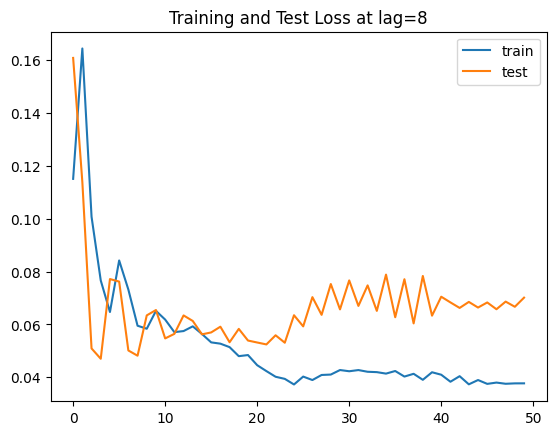

In [220]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.title('Training and Test Loss at lag=8')
pyplot.legend()
pyplot.show()

Interesting.  I'll have to come back and look into this.

### Model Performance Metrics  

Repeated as for lag = 4, but now with lag = 8.

Requires debugging.

22/22 [==============================] - 0s 1ms/step


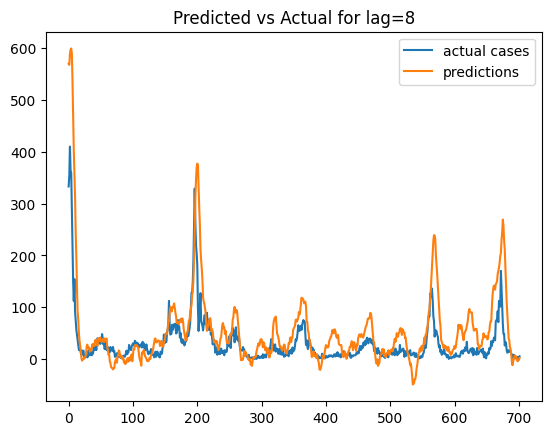

In [221]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_weeks*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -14:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -14:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# plot actual and predicted
pyplot.plot(inv_y, label='actual cases')
pyplot.plot(inv_yhat, label='predictions')
pyplot.title('Predicted vs Actual for lag=8')
pyplot.legend()
pyplot.show()

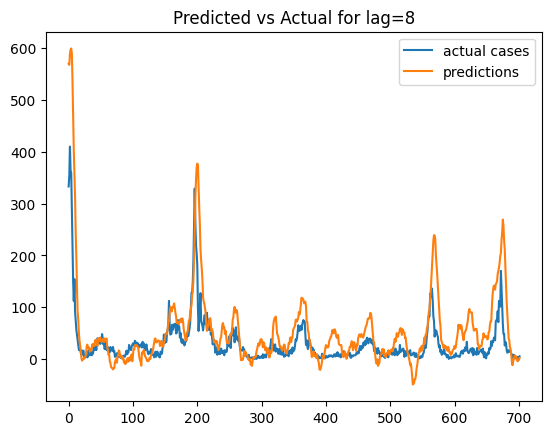

In [222]:
# plot actual and predicted
pyplot.plot(inv_y, label='actual cases')
pyplot.plot(inv_yhat, label='predictions')
pyplot.title('Predicted vs Actual for lag=8')
pyplot.legend()
pyplot.show()

In [223]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
# calculate MAE
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.3f' % mae)

Test RMSE: 54.872
Test MAE: 32.338


The RMSE and MAE climb considerably at lag 8.  It would seem lag 8 isn't a great choice.  Changing the train_frac (effectively the training and test set sizes) could produce interesting results.  The test MAE improved on the lag 4 case with a larger training size, as one would expect.

The LSTM model runs fast enough that one could trial time lags 1 through 10 with relative ease.  This may be added if there's time to revisit this model.

### Let's try pipelines  

Ok, first... why?  Besides the promise of scalability (via standardization and automation), and the possibility to optimize whatever tunable parameters are at our disposal, pipelining might allow to scale at the appropriate time (*before train_test_split*) and have it inverted on the 'way out' to produce the desired model metrics in the original scale.

The below example is taken from the lecture on pipelining tasks for modelling.  I'll adapt it to my situation.

In [224]:
# from sklearn.pipeline import Pipeline

# pipeline = Pipeline(steps=[
#     ('scaling', StandardScaler()),
#     ('pca', PCA(n_components=3)),
#     ('classifier', LogisticRegression())
# ])

# pipeline.fit(X_train, y_train)

# y_pred = pipeline.predict(X_test)
# acc = accuracy_score(y_test, y_pred)
# print(f'Test set accuracy: {acc}')

The below tests the various pieces before assembling - a few cells down - into a pipeline.

First I'll get my steps done in the proper order, ensuring scaling is done *after* the train test split to avoid leaking test data.  Once I'm satisfied the steps are done in the right order, and that the array dimensions work to run the LSTM, then this will be pipelined.

In [225]:
# For input to series_to_supervised
values = sj_df.values

# ensure all data is float
values_to_pipe = values.astype('float32')

# specify the number of lag hours
# optimal lags found in eda_multivariate vary from 0 to 14, with one group on the lower end, 
# and one group closer to 8.  We can try 4 and then try 8, we'll see what that does to performance.
n_weeks = 8 
n_features = 15 # 14 inputs, 1 output: all 15 of them are lagged to create the input features (so the target itself lagged is an input feature too)

# frame as supervised learning
reframed_for_pipe = series_to_supervised_mv(values_to_pipe, n_weeks, 1)

#print(reframed.head())
reframed_for_pipe.head()

,var1(t-8),var2(t-8),var3(t-8),var4(t-8),var5(t-8),var6(t-8),var7(t-8),var8(t-8),var9(t-8),var10(t-8),var11(t-8),var12(t-8),var13(t-8),var14(t-8),var15(t-8),var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var6(t-7),var7(t-7),var8(t-7),var9(t-7),var10(t-7),var11(t-7),var12(t-7),var13(t-7),var14(t-7),var15(t-7),var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),var6(t-6),var7(t-6),var8(t-6),var9(t-6),var10(t-6),var11(t-6),var12(t-6),var13(t-6),var14(t-6),var15(t-6),var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var6(t-5),var7(t-5),var8(t-5),var9(t-5),var10(t-5),var11(t-5),var12(t-5),var13(t-5),var14(t-5),var15(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var6(t-4),var7(t-4),var8(t-4),var9(t-4),var10(t-4),var11(t-4),var12(t-4),var13(t-4),var14(t-4),var15(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var9(t-3),var10(t-3),var11(t-3),var12(t-3),var13(t-3),var14(t-3),var15(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var7(t-2),var8(t-2),var9(t-2),var10(t-2),var11(t-2),var12(t-2),var13(t-2),var14(t-2),var15(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var15(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t),var13(t),var14(t),var15(t)
8,4.0,0.122600,0.103725,0.198483,0.177617,297.572845,297.742859,292.414276,299.799988,295.899994,32.000000,73.365715,12.420000,14.012857,2.628572,5.0,0.169900,0.142175,0.162357,0.155486,298.211426,298.442871,293.951416,300.899994,296.399994,17.940001,77.368568,22.820000,15.372857,2.371428,4.0,0.032250,0.172967,0.157200,0.170843,298.781433,298.878571,295.434296,300.500000,297.299988,26.100000,82.052856,34.540001,16.848572,2.300000,3.0,0.128633,0.245067,0.227557,0.235886,298.987152,299.228577,295.309998,301.399994,297.000000,13.900000,80.337143,15.360000,16.672857,2.428571,6.0,0.19620,0.262200,0.251200,0.247340,299.518585,299.664276,295.821442,301.899994,297.500000,12.200000,80.459999,7.520000,17.209999,3.014286,2.0,0.19620,0.174850,0.254314,0.181743,299.630005,299.764282,295.851440,302.399994,298.100006,26.490000,79.891426,9.580000,17.212856,2.100000,4.0,0.112900,0.092800,0.205071,0.210271,299.207153,299.221436,295.865723,301.299988,297.700012,38.599998,82.000000,3.480000,17.234285,2.042857,5.0,0.072500,0.072500,0.151471,0.133029,299.591431,299.528564,296.531433,300.600006,298.399994,30.000000,83.375717,151.119995,17.977142,1.571429,10.0,0.102450,0.146175,0.125571,0.123600,299.578583,299.557129,296.378571,302.100006,297.700012,37.509998,82.768570,19.320000,17.790001,1.885714
9,5.0,0.169900,0.142175,0.162357,0.155486,298.211426,298.442871,293.951416,300.899994,296.399994,17.940001,77.368568,22.820000,15.372857,2.371428,4.0,0.032250,0.172967,0.157200,0.170843,298.781433,298.878571,295.434296,300.500000,297.299988,26.100000,82.052856,34.540001,16.848572,2.300000,3.0,0.128633,0.245067,0.227557,0.235886,298.987152,299.228577,295.309998,301.399994,297.000000,13.900000,80.337143,15.360000,16.672857,2.428571,6.0,0.196200,0.262200,0.251200,0.247340,299.518585,299.664276,295.821442,301.899994,297.500000,12.200000,80.459999,7.520000,17.209999,3.014286,2.0,0.19620,0.174850,0.254314,0.181743,299.630005,299.764282,295.851440,302.399994,298.100006,26.490000,79.891426,9.580000,17.212856,2.100000,4.0,0.11290,0.092800,0.205071,0.210271,299.207153,299.221436,295.865723,301.299988,297.700012,38.599998,82.000000,3.480000,17.234285,2.042857,5.0,0.072500,0.072500,0.151471,0.133029,299.591431,299.528564,296.531433,300.600006,298.399994,30.000000,83.375717,151.119995,17.977142,1.571429,10.0,0.102450,0.146175,0.125571,0.123600,299.578583,299.557129,296.378571,302.100006,297.700012,37.509998,82.768570,19.320000,17.790001,1.885714,6.0,0.102450,0.121550,0.160683,0.202567,300.154297,300.278564,296.651428,302.299988,298.700012,28.400000,81.281425,14.410000,18.071428,2.014286
10,4.0,0.032250,0.172967,0.157200,0

Now we use train_test_split_rows_reserved to split up the data prior to applying any scaling.  There's no particular strategy employed here for the split, like identifying a number of cycles and ensuring there's enough in the train and test sets.  It's just a simple split respecting the sequential nature of the data.

In [226]:
test_frac = 0.75
values = reframed_for_pipe.values
print(values)
train, test = train_test_split_rows_reserved(values,int(test_frac*sj_df.shape[0]))    
print(len(train))
print(len(test))

[[ 4.00000000e+00  1.22599997e-01  1.03725001e-01  1.98483303e-01  1.77616701e-01  2.97572845e+02  2.97742859e+02  2.92414276e+02  2.99799988e+02  2.95899994e+02  3.20000000e+01  7.33657150e+01  1.24200001e+01  1.40128574e+01  2.62857151e+00  5.00000000e+00  1.69900000e-01  1.42175004e-01  1.62357107e-01  1.55485705e-01  2.98211426e+02  2.98442871e+02  2.93951416e+02  3.00899994e+02  2.96399994e+02  1.79400005e+01  7.73685684e+01  2.28199997e+01  1.53728571e+01  2.37142849e+00  4.00000000e+00  3.22499983e-02  1.72966704e-01  1.57199994e-01  1.70842901e-01  2.98781433e+02  2.98878571e+02  2.95434296e+02  3.00500000e+02  2.97299988e+02  2.61000004e+01  8.20528564e+01  3.45400009e+01  1.68485718e+01  2.29999995e+00  3.00000000e+00  1.28633305e-01  2.45066702e-01  2.27557093e-01  2.35885695e-01  2.98987152e+02  2.99228577e+02  2.95309998e+02  3.01399994e+02  2.97000000e+02  1.38999996e+01  8.03371429e+01  1.53599997e+01  1.66728573e+01  2.42857146e+00  6.00000000e+00  1.96199998e-01  2.621

Now we remove those columns we don't intend to use: these were produced as a result of series_to_supervised when all variables (features and target) are lagged by the specified lag order.  We correctly assign the input features to the X train and test sets, while assigning the target at time t to the y train and test sets.

In [227]:
# split into input and outputs; this is where the undesired columns are dropped,
# as opposed to where they were dropped in the one time lag case
n_obs = n_weeks * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features] # if everything was done correctly when the dataframe was hauled in, the target at time t is 15 columns from the end
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)


(226, 120) 226 (226,)


How to implement an LSTM within a sklearn pipeline?  

There are a few resources, not necessarily specific to LSTM models, but possibly helpful:
* https://stackoverflow.com/questions/42415076/how-to-insert-keras-model-into-scikit-learn-pipeline, leading to...  
* https://queirozf.com/entries/scikit-learn-pipeline-examples#keras-model (pretty complete example using scaler, keras, gridsearch, all-in-one)
* one site says to try skorch (https://github.com/skorch-dev/skorch)  
* one take on hyperparameter tuning:  https://stackoverflow.com/questions/77007252/how-to-perform-hyperparameter-tuning-of-lstm-using-gridsearchcv  (the questioner does make one silly mistake - I've done it too, not judging - by using accuracy score for a regression ;)  

This guy seems to take a swing at it for LSTMs, but didn't post his final solution (if he arrived at one):  
https://stackoverflow.com/questions/50750628/how-to-scale-impute-a-tensor-in-a-sklearn-pipeline-for-input-to-a-keras-lstm   

The below tries out components first, then it's assembled into a pipeline further below.

In [228]:
# commented out while trying pipelines, but required for the "component-based" approach below.

# # scale the inputs here (note this differs from Brownlee's scaling: he did it before the series_to_supervised and before train_test_split... why?)
# scaler = MinMaxScaler()
# train_X_scaled = scaler.fit_transform(train_X)
# test_X_scaled = scaler.transform(test_X)

# # reshape input to be 3D [samples, timesteps, features]
# train_X_scaled = train_X_scaled.reshape((train_X_scaled.shape[0], n_weeks, n_features))
# test_X_scaled = test_X_scaled.reshape((test_X_scaled.shape[0], n_weeks, n_features))

# print(train_X_scaled.shape, train_y.shape, test_X_scaled.shape, test_y.shape)

# from scikeras.wrappers import KerasRegressor

# def create_model():
#     model = Sequential()
#     model.add(LSTM(50, input_shape=(train_X_scaled.shape[1], train_X_scaled.shape[2])))
#     model.add(Dense(1))
#     model.compile(loss='mae', optimizer='adam')
    
#     return model

# # # not sure how to work in the validation data part that was used before.  It was used before to get training & testing loss plots.  I'll come back to this.
# # history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# # wrap the model using the function you created
# regressor = KerasRegressor(build_fn=create_model, epochs=50, batch_size=72, verbose=0)

# #history = model.fit(train_X_scaled, train_y, epochs=50, batch_size=72, verbose=0) # if we're avoiding use of the scikit learn wrapper KerasRegressor

# regressor.fit(train_X_scaled, train_y)

# y_pred = regressor.predict(test_X_scaled)
# #y_pred = model.predict(test_X_scaled) # sans KerasRegressor wrapper

# mae = mean_absolute_error(test_y, y_pred)
# print(f'Test set accuracy: {mae}')

Now we know the components work.  Time to assemble all of this into a pipeline.

Ran into a few issues passing variables around. The below gets around this.

In [229]:
from scikeras.wrappers import KerasRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

scaler = MinMaxScaler()

def create_model():
    model = Sequential()
    model.add(LSTM(50, input_shape=(n_weeks, n_features)))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    
    return model

regressor = KerasRegressor(build_fn=create_model, epochs=50, batch_size=72, verbose=0)

pipeline = Pipeline(steps=[
    ('scaling', scaler),
    ('reshape', FunctionTransformer(lambda X: X.reshape((X.shape[0], n_weeks, n_features)))),
    ('regressor', regressor)
])

pipeline.fit(train_X, train_y)
y_pred = pipeline.predict(test_X)
mae_piped = mean_absolute_error(test_y, y_pred)
print(f'Test set accuracy: {mae_piped}')

c:\Users\ron_d\anaconda3\envs\lhl_ds\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Test set accuracy: 22.126638412475586


Now I need to investigate using optuna to do pipelines.  Apparently it's worth it.